> Adapted from *Machine Learning with PyTorch and Scikit-Learn* by Raschka et al.  
> Figures and selected functions used under CC BY-NC 4.0.  
> Markdown content and examples modified for educational use in neuroscience.

# A Tour of Machine Learning Classifiers and Dimensionality Reduction
**Chapter 3/3 — Adapted for SNEU20007U Computational Neuroscience**

**This notebook contains interactive widgets.**  
To run it live in your browser, click the badge below:

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/BergLab/CompNeuroCourse/HEAD?filepath=notebooks%2FML_joao%2Fch03_expanded.ipynb)

---

In this notebook, we explore some of the most important classification algorithms used in machine learning, alongside powerful tools for dimensionality reduction. Our goal is to understand both how these models make decisions and how we can visualize and interpret high-dimensional neuroscience-inspired data.

We will work with a synthetic dataset of neuron waveform features derived from prototypical firing types (Interneuron, Pyramidal, Bursting). Through this dataset, you'll apply both classification and dimensionality reduction techniques that are broadly useful in neuroscience, neuroimaging, and biomedical data analysis.

## Topics Covered

### Classification
- Logistic Regression (OvR and Multinomial)
- Support Vector Machines (linear and RBF kernels)
- Decision Trees
- k-Nearest Neighbors (k-NN)

### Dimensionality Reduction
- Principal Component Analysis (PCA)
- Linear Discriminant Analysis (LDA)
- t-distributed Stochastic Neighbor Embedding (t-SNE)

## Key Skills Practiced

- Comparing classifier decision boundaries
- Interpreting logistic vs. margin-based models (SVM)
- Visualizing decision trees and understanding splits
- Applying and interpreting PCA, LDA, t-SNE
- Using interactive widgets to explore model hyperparameters
- Making informed choices between full vs. reduced feature spaces

This notebook is designed to offer hands-on exposure and build intuition, even for students with limited programming and mathematical background. If you're unsure about something, explore it interactively and discuss with your peers or instructors!

Let’s begin by loading our synthetic neuron dataset and preparing it for analysis.


In [37]:
from ch03_expanded import load_synthetic_neurons_3class

# Load data
X, y, df = load_synthetic_neurons_3class(as_frame=True, overlap=0.8)
df.head()


,spike_width,amplitude,upstroke_downstroke,symmetry_index,neuron_type
0,0.262189,35.840064,1.320072,0.875245,Interneuron
1,0.171959,34.791282,1.220454,0.774701,Interneuron
2,0.249328,36.587824,1.340704,0.862223,Interneuron
3,0.252641,44.508965,1.274801,0.731257,Interneuron
4,0.264750,36.164470,1.340552,0.796006,Interneuron


# Modeling Class Probabilities via Logistic Regression

Logistic regression is a **linear classifier** that models the **probability** that a sample belongs to a given class. Unlike the perceptron, which only outputs a class label, logistic regression provides **real-valued probabilities**, which are particularly useful in medical and neuroscience settings where uncertainty matters.

For binary classification, the logistic regression model uses the **logistic sigmoid function**:

$$
P(y = 1 \mid \mathbf{x}) = \frac{1}{1 + e^{-z}}, \quad \text{where } z = \mathbf{w}^T \mathbf{x} + b
$$

This expression maps any real-valued input to a value between 0 and 1. The model estimates the probability that the sample belongs to class 1, and class 0 is simply the complement.

<!-- <img src="./figures/03_02.png" width="600"> -->
![Logistic Sigmoid Function](figures/03_02.png)

## Log-Odds Interpretation

Instead of modeling class labels directly, logistic regression models the **log-odds** (or *logit*) of the positive class:

$$
\log \left( \frac{P(y = 1 \mid \mathbf{x})}{1 - P(y = 1 \mid \mathbf{x})} \right) = \mathbf{w}^T \mathbf{x} + b
$$

This linear relationship between the features and the log-odds makes logistic regression interpretable and effective for linearly separable data.

<!-- <img src="./figures/03_03.png" width="600"> -->
![Logistic Regression](figures/03_03.png)

## Training: The Logistic Loss

The logistic regression model is trained by minimizing the **log-loss** (also known as binary cross-entropy):

$$
\mathcal{L} = - \sum_{i=1}^{n} \left[ y^{(i)} \log(\hat{p}^{(i)}) + (1 - y^{(i)}) \log(1 - \hat{p}^{(i)}) \right]
$$

Where:
- $y^{(i)}$ is the true label
- $\hat{p}^{(i)}$ is the predicted probability for class 1

This loss function penalizes incorrect predictions more severely when the model is confident but wrong.

<!-- <img src="./figures/03_25.png" width="600"> -->

## From Binary to Multiclass Classification

For problems with more than two classes (like our 3-class synthetic neuron dataset), logistic regression can be extended using either:

- **One-vs-Rest (OvR)**: Train a separate binary classifier for each class vs. the rest
- **Multinomial (Softmax)**: Generalize the sigmoid function to output a probability distribution over all classes

Scikit-learn's `LogisticRegression` supports both approaches and defaults to **multinomial** when using the `'lbfgs'` solver and `multi_class='multinomial'`.

We will now train a logistic regression model on our **standardized synthetic neuron waveform dataset**, and visualize how well it separates the neuron types in feature space.


In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

# Preprocess
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

# Train logistic regression
lr = LogisticRegression(multi_class='ovr', solver='lbfgs', C=100.0, random_state=1)
lr.fit(X_train_std, y_train)
y_pred = lr.predict(X_test_std)

print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 1.0


c:\Users\jhc23\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


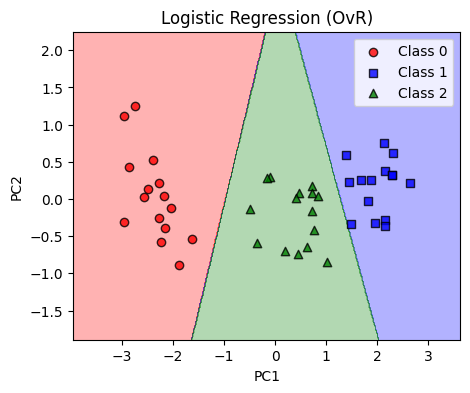

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, title="", resolution=0.02):
    # Only use first 2 PCA components
    pca = PCA(n_components=2)
    X_proj = pca.fit_transform(X)
    
    markers = ('o', 's', '^')
    colors = ('red', 'blue', 'green')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X_proj[:, 0].min() - 1, X_proj[:, 0].max() + 1
    x2_min, x2_max = X_proj[:, 1].min() - 1, X_proj[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    Z = classifier.predict(pca.inverse_transform(np.array([xx1.ravel(), xx2.ravel()]).T))
    Z = Z.reshape(xx1.shape)
    
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X_proj[y == cl, 0], y=X_proj[y == cl, 1],
                    alpha=0.8, c=colors[idx], marker=markers[idx], label=f'Class {cl}',
                    edgecolor='black')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(title)
    plt.legend()

# Plot decision boundary
plt.figure(figsize=(5,4))
plot_decision_regions(X_test_std, y_test, classifier=lr, title="Logistic Regression (OvR)")
plt.show()


# Visualizing Decision Boundaries: Logistic Regression vs. Support Vector Machines (SVM)

In this section, we compare two widely used **linear classifiers** on our synthetic 3-class neuron dataset: **Logistic Regression** and **Support Vector Machines (SVM)**. The goal is to build an **intuitive understanding** of how they learn to separate classes — and how their behavior changes with different hyperparameters.


## Support Vector Machines (SVM): Margin-Based Classifier

SVMs take a different approach: rather than modeling probabilities, they search for the **decision boundary that maximizes the margin** — the distance between the closest training points (support vectors) of each class and the separating hyperplane.

For **linearly separable** data, this works beautifully. However, real data (like neurons) is rarely perfectly separable. To handle this, SVMs introduce:

- **Slack variables**: allow some misclassification during training
- **Kernel tricks**: transform the data into higher-dimensional space

### RBF Kernel: Learning Nonlinear Boundaries

The **Radial Basis Function (RBF)** kernel maps samples into a higher-dimensional space, enabling the SVM to learn **nonlinear** decision boundaries. It computes similarity between points using:

$$
K(\mathbf{x}, \mathbf{x}') = \exp(-\gamma \|\mathbf{x} - \mathbf{x}'\|^2)
$$

**Hyperparameters:**
- **`C`**: Penalty for misclassification.  
  - High `C` → narrow margin, fewer violations
  - Low `C` → wider margin, more tolerance
- **`gamma`**: Controls the radius of influence of each data point.
  - High `gamma` → each point affects only nearby regions (complex, wiggly boundary)
  - Low `gamma` → broader influence (smoother, simpler boundary)

---

## What You Can Explore Below

The widget below lets you interactively:

- Switch between **Logistic Regression** and **SVM**
- Adjust the **`C` (regularization)** parameter
- Modify the **`gamma`** parameter (for SVM only)

We'll visualize the decision boundaries in a 2D plane using two features from the neuron dataset (e.g., spike width and amplitude). These boundaries are computed after training the model, and illustrate how different hyperparameters **reshape the classification landscape**.

Use this tool to build geometric and probabilistic intuition around these foundational classifiers.

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from ipywidgets import interact, FloatLogSlider, Dropdown, fixed
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=f'Class {cl}', 
                    edgecolor='black')
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], 
                    facecolors='none', edgecolor='black', 
                    linewidth=1, marker='o', 
                    s=100, label='Test set')

def interactive_classifier_demo(X_train, y_train, X_test, y_test):
    X_combined = np.vstack((X_train, X_test))
    y_combined = np.hstack((y_train, y_test))

    @interact(
        model=Dropdown(options=['Logistic Regression', 'SVM'], value='Logistic Regression'),
        C=FloatLogSlider(value=1.0, base=10, min=-2, max=3, step=0.2, description='C (Reg)'),
        gamma=FloatLogSlider(value=0.1, base=10, min=-3, max=1, step=0.2, description='Gamma')
    )
    def update(model, C, gamma):
        if model == 'Logistic Regression':
            clf = LogisticRegression(C=C, multi_class='ovr', solver='lbfgs', random_state=1)
        else:
            clf = SVC(kernel='rbf', C=C, gamma=gamma, random_state=1)

        clf.fit(X_train, y_train)
        plot_decision_regions(X_combined, y_combined, classifier=clf, test_idx=range(len(y_train), len(y_combined)))
        plt.title(f"{model} Decision Boundary")
        plt.xlabel("Feature 1 [standardized]")
        plt.ylabel("Feature 2 [standardized]")
        plt.legend(loc='upper left')
        plt.show()



In [41]:
interactive_classifier_demo(X_train_std[:, [0, 1]], y_train, X_test_std[:, [0, 1]], y_test)

interactive(children=(Dropdown(description='model', options=('Logistic Regression', 'SVM'), value='Logistic Re…

# Exploring Decision Trees and k-Nearest Neighbors (k-NN)

Beyond linear classifiers like logistic regression and SVMs, there are **non-parametric models** that use entirely different intuitions to separate data. Here, we examine two such models:

- **Decision Trees**: Divide the feature space with axis-aligned splits
- **k-Nearest Neighbors (k-NN)**: Classify based on proximity in feature space

Both of these algorithms are easy to understand and visualize, making them excellent tools for developing an **intuition about model complexity**, **overfitting**, and **decision boundaries**.


## Decision Trees

A decision tree classifier recursively partitions the input space by asking a series of **if-then rules** based on feature thresholds:

- At each node, the algorithm selects the feature and threshold that most effectively split the data.
- The process continues until some stopping criterion is met (e.g., maximum depth or minimum samples per leaf).

Formally, it optimizes a splitting criterion like the **Gini impurity**:

$$
\text{Gini}(t) = 1 - \sum_{k=1}^K p_k(t)^2
$$

Where \( p_k(t) \) is the proportion of samples from class \( k \) at node \( t \).

> Decision trees can easily **overfit** if grown too deep, but they’re interpretable and fast.

**Hyperparameter:**  
- `max_depth`: Maximum number of splits from root to leaf. Lower values reduce overfitting.


## k-Nearest Neighbors (k-NN)

k-NN is a **lazy learning algorithm** — it makes no model during training, and simply stores the training data. 
Given a new point to classify, k-NN follows the steps:
1. Compute the Euclidean distance (or another metric) to all training samples.
2. Identify the `k` closest neighbors.
3. Return the most common class label among them.

<!-- <img src="./figures/03_23.png" width="300"> -->
![k-NN](figures/03_23.png)

It relies entirely on the **geometry of the feature space**, and the shape of the decision boundary can be **highly nonlinear**.

> The model complexity depends on the value of \( k \). Small \( k \) leads to sharp, irregular boundaries, while large \( k \) smooths them out.

**Hyperparameter:**  
- `k`: Number of neighbors to consider.  
  - Lower values increase model variance (more sensitive to noise)  
  - Higher values increase bias (more conservative decisions)

---

## What You Can Explore Below

Use the widget to:
- Switch between **Decision Tree** and **k-NN**
- Adjust **`max_depth`** for trees or **`k`** for neighbors
- Observe how the **decision boundary changes** based on model complexity

We apply these models to two features of our neuron waveform dataset, helping you build a **visual intuition** for how different classifiers carve up the input space.


In [47]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from ipywidgets import interact, IntSlider
import numpy as np

def interactive_tree_plot(X_train, y_train, X_test, y_test, feature_names):
    """
    Show an interactive decision tree boundary plot with the tree structure.
    """

    def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
        markers = ('o', 's', '^')
        colors = ('red', 'blue', 'lightgreen')
        cmap = ListedColormap(colors[:len(np.unique(y))])

        x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                               np.arange(x2_min, x2_max, resolution))
        Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
        Z = Z.reshape(xx1.shape)
        plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
        plt.xlim(xx1.min(), xx1.max())
        plt.ylim(xx2.min(), xx2.max())

        for idx, cl in enumerate(np.unique(y)):
            plt.scatter(X[y == cl, 0], X[y == cl, 1],
                        alpha=0.8, c=colors[idx],
                        marker=markers[idx], label=f'Class {cl}',
                        edgecolor='black')
        if test_idx:
            X_test_, y_test_ = X[test_idx, :], y[test_idx]
            plt.scatter(X_test_[:, 0], X_test_[:, 1],
                        facecolors='none', edgecolor='black',
                        linewidth=1, marker='o',
                        s=100, label='Test set')

    @interact(max_depth=IntSlider(min=1, max=50, step=1, value=3, description='max_depth'))
    def update(max_depth):
        clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
        clf.fit(X_train, y_train)

        X_combined = np.vstack((X_train, X_test))
        y_combined = np.hstack((y_train, y_test))
        test_idx = range(len(y_train), len(y_combined))

        fig, axes = plt.subplots(1, 2, figsize=(14, 8))

        plt.sca(axes[0])
        plot_decision_regions(X_combined, y_combined, classifier=clf, test_idx=test_idx)
        plt.title(f"Decision Boundary (max_depth={max_depth})")
        plt.xlabel(feature_names[0])
        plt.ylabel(feature_names[1])
        plt.legend(loc='upper left')

        plt.sca(axes[1])
        plot_tree(clf, feature_names=feature_names, class_names=[str(c) for c in np.unique(y_train)],
                  filled=True, rounded=True)
        plt.title("Tree Structure")

        plt.tight_layout()
        plt.show()


In [ ]:
# Plot here
feature_names = [df.columns[0], df.columns[1]]
interactive_tree_plot(X_train_std[:, [0, 1]], y_train, X_test_std[:, [0, 1]], y_test, feature_names)

interactive(children=(IntSlider(value=3, description='max_depth', max=50, min=1), Output()), _dom_classes=('wi…

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from ipywidgets import interact, IntSlider, Dropdown
import matplotlib.pyplot as plt

def interactive_tree_knn_demo(X_train, y_train, X_test, y_test):
    X_combined = np.vstack((X_train, X_test))
    y_combined = np.hstack((y_train, y_test))

    @interact(
        model=Dropdown(options=['Decision Tree', 'K-Nearest Neighbors'], value='Decision Tree'),
        depth=IntSlider(value=4, min=1, max=50, step=1, description='Max Depth'),
        k=IntSlider(value=5, min=1, max=50, step=1, description='K (Neighbors)')
    )
    def update(model, depth, k):
        if model == 'Decision Tree':
            clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
            title = f"Decision Tree (max_depth={depth})"
        else:
            clf = KNeighborsClassifier(n_neighbors=k)
            title = f"K-Nearest Neighbors (k={k})"

        clf.fit(X_train, y_train)
        plot_decision_regions(X_combined, y_combined, classifier=clf, test_idx=range(len(y_train), len(y_combined)))
        plt.title(title)
        plt.xlabel("Feature 1 [standardized]")
        plt.ylabel("Feature 2 [standardized]")
        plt.legend(loc='upper left')
        plt.show()



In [36]:
# Example usage:
interactive_tree_knn_demo(X_train_std[:, [0, 1]], y_train, X_test_std[:, [0, 1]], y_test)

interactive(children=(Dropdown(description='model', options=('Decision Tree', 'K-Nearest Neighbors'), value='D…

# Why Reduce Dimensionality?

In the previous sections, we explored several classifiers — logistic regression, SVMs, decision trees, and k-NN — and saw how they try to draw decision boundaries in high-dimensional feature spaces.

But as our datasets grow more complex — with dozens or even hundreds of features per neuron, patient, or time point — two key challenges arise:

## Interpretation

High-dimensional data is hard to **visualize** and even harder to **understand**. As neuroscientists or clinicians, we often want to answer:
- Are there hidden clusters in the data?
- Can we summarize key differences between cell types or conditions?
- Can we map our data to a **2D space** where structure becomes apparent?

## Efficiency

Many machine learning algorithms perform poorly in very high-dimensional spaces, a phenomenon known as the **curse of dimensionality**. Reducing dimensionality helps by:
- Speeding up training
- Filtering out noise and redundancy
- Improving generalization

## Enter Dimensionality Reduction

Dimensionality reduction methods transform our feature space into a lower-dimensional representation that **preserves key information**. Depending on the method, this might mean:
- Preserving overall variance (PCA)
- Enhancing class separation (LDA)
- Preserving local neighborhood structure (t-SNE)

These techniques are not just for making pretty plots — they often **reveal hidden structure**, help detect outliers, and clarify relationships that are obscured in raw data.

We'll now explore three powerful methods — **PCA**, **LDA**, and **t-SNE** — to compress our 4D synthetic neuron dataset into two dimensions and investigate how well neuron types separate.


...

## Principal Component Analysis (PCA)

**PCA** is a widely used **unsupervised** technique for dimensionality reduction and exploratory data analysis. It projects high-dimensional data onto a lower-dimensional subspace while preserving as much of the **variance** (information) as possible.

<img src="./figures/05_01.png" width="300">

This is especially useful in neuroscience, where data from electrophysiology, imaging, or gene expression can have **many correlated variables**. PCA helps us summarize these variables using fewer, **uncorrelated components**.

### Mathematical Formulation

Given a standardized dataset \( X \in \mathbb{R}^{n \times d} \), PCA finds a linear projection matrix \( W \in \mathbb{R}^{d \times k} \), such that the transformed data:

$$
Z = XW
$$

captures the directions of **maximum variance** (the so-called **principal components**).

The steps are:
1. Standardize the features.
2. Compute the **covariance matrix**.
3. Perform **eigendecomposition** to obtain eigenvalues and eigenvectors.
4. Select the top \( k \) eigenvectors (those with the highest eigenvalues).
5. Project the data onto this new subspace.

Each principal component corresponds to a linear combination of original features and is **orthogonal** to the others.

### Hyperparameters
- `n_components`: Number of components to keep.
  - Choose this to balance **dimensionality** and **explained variance**.
  - Example: 2 components may explain >90% of variance in some datasets.

### Notes
- PCA **does not use class labels** — it's purely data-driven.
- Useful for **visualization**, **denoising**, and avoiding the **curse of dimensionality**.
- Highly sensitive to **scaling** — always standardize your data!

We'll now apply PCA to our synthetic neuron data to visualize class separation in two dimensions.


In [ ]:
from sklearn.decomposition import PCA
import pandas as pd

def plot_pca_interactive(X, y, feature_names, class_labels=None):
    """
    PCA projection with class-colored 2D scatter, explained variance bar plot, and feature loadings.
    Preserves color and class label consistency.
    """
    pca = PCA(n_components=len(feature_names))
    X_pca = pca.fit_transform(X)
    explained_var = pca.explained_variance_ratio_
    loadings = pd.DataFrame(
        pca.components_.T * np.sqrt(pca.explained_variance_),
        columns=[f"PC{i+1}" for i in range(len(feature_names))],
        index=feature_names
    )

    if class_labels is None:
        class_labels = {i: f"Class {i}" for i in np.unique(y)}

    colors = ['red', 'blue', 'green']
    markers = ['o', 's', '^']

    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    # PCA scatter plot
    ax = axs[0, 0]
    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(X_pca[y == cl, 0], X_pca[y == cl, 1],
                   c=colors[idx], marker=markers[idx],
                   label=class_labels[cl], alpha=0.7, edgecolor='black')
    ax.set_title("PCA: PC1 vs PC2")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.legend()

    # Explained variance
    axs[0, 1].bar(range(1, len(explained_var)+1), explained_var * 100,
                  color='skyblue', edgecolor='black')
    axs[0, 1].set_title("Explained Variance by PC")
    axs[0, 1].set_xlabel("Principal Components")
    axs[0, 1].set_ylabel("% Variance")

    # Feature loadings for PC1
    axs[1, 0].bar(loadings.index, loadings["PC1"], color='steelblue')
    axs[1, 0].set_title("Feature Loadings on PC1")
    axs[1, 0].tick_params(axis='x', rotation=45)

    # Feature loadings for PC2
    axs[1, 1].bar(loadings.index, loadings["PC2"], color='darkorange')
    axs[1, 1].set_title("Feature Loadings on PC2")
    axs[1, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


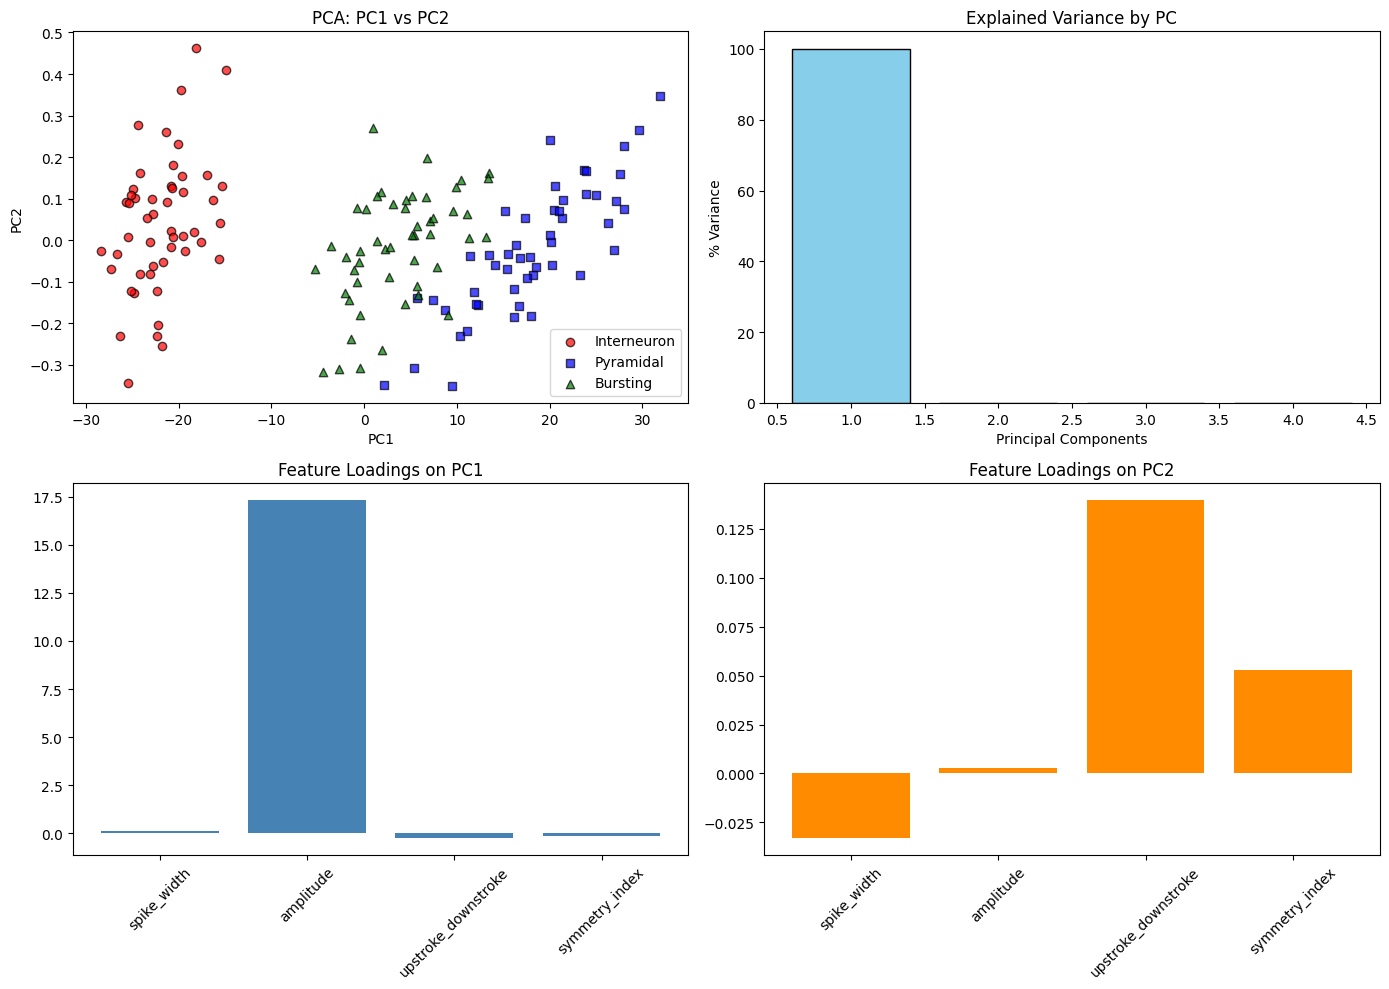

In [59]:
plot_pca_interactive(X, y, df.columns[:-1], class_labels={0: "Interneuron", 1: "Pyramidal", 2: "Bursting"})

## Linear Discriminant Analysis (LDA)

**LDA** is a **supervised** technique for dimensionality reduction. Unlike PCA, which finds directions of maximum variance, LDA identifies axes that **maximize class separability**.

<img src="./figures/05_06.png" width="300">

This makes LDA particularly useful in **classification problems**, like distinguishing neuron types based on waveform features or gene expression patterns.

### Objective

LDA projects the data onto a lower-dimensional space such that the **between-class variance** is maximized and the **within-class variance** is minimized.

Mathematically, it finds the projection matrix \( W \) that maximizes the ratio:

$$
W^* = \arg \max_W \frac{ |W^T S_B W| }{ |W^T S_W W| }
$$

Where:
- \( S_B \) is the **between-class scatter matrix**
- \( S_W \) is the **within-class scatter matrix**

### Steps:
1. Standardize the dataset.
2. Compute mean vectors for each class.
3. Calculate \( S_W \) and \( S_B \).
4. Solve the generalized **eigenvalue problem** for \( S_W^{-1} S_B \).
5. Select the top \( k = c - 1 \) eigenvectors (where \( c \) is the number of classes).
6. Project the data onto the new subspace.

### Hyperparameters
- `n_components`: Number of discriminant axes (≤ number of classes - 1).

### Notes
- LDA performs well when class covariances are **equal** and data is **normally distributed**.
- Even if assumptions are mildly violated, LDA can still perform robustly in practice.
- It’s great for **visualizing and improving classification**, but not ideal when features outnumber samples.

We'll now use LDA to compress our 4D neuron data into 2D — with the goal of separating neuron classes clearly.

In [62]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

def plot_lda_interactive(X, y, class_labels=None):
    """
    LDA plot with:
    - LDA 2D projection using consistent colors and labels
    - Discriminability (explained variance) bar chart
    """
    lda = LDA(n_components=2)
    X_lda = lda.fit_transform(X, y)
    discr = lda.explained_variance_ratio_

    if class_labels is None:
        class_labels = {i: f"Class {i}" for i in np.unique(y)}

    colors = ['red', 'blue', 'green']
    markers = ['o', 's', '^']

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # LDA scatter
    for idx, cl in enumerate(np.unique(y)):
        axs[0].scatter(X_lda[y == cl, 0], X_lda[y == cl, 1],
                       label=class_labels[cl],
                       alpha=0.7, c=colors[idx], marker=markers[idx], edgecolor='black')
    axs[0].set_title("LDA: LD1 vs LD2")
    axs[0].set_xlabel("LD1")
    axs[0].set_ylabel("LD2")
    axs[0].legend()

    # Discriminability
    axs[1].bar(["LD1", "LD2"], discr * 100, color='purple')
    axs[1].set_title("Discriminability (%)")
    axs[1].set_ylabel("% Discriminability")

    plt.tight_layout()
    plt.show()


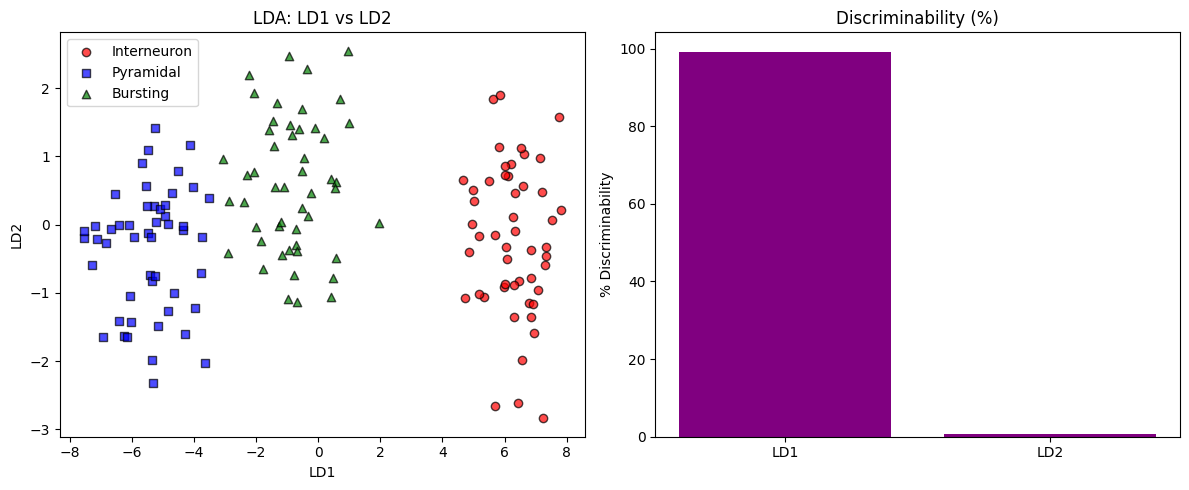

In [64]:
plot_lda_interactive(X, y, class_labels={0: "Interneuron", 1: "Pyramidal", 2: "Bursting"})

## t-distributed Stochastic Neighbor Embedding (t-SNE)

**t-SNE** is a **nonlinear** technique for **visualizing** high-dimensional data in 2 or 3 dimensions. Unlike PCA or LDA, t-SNE focuses on preserving the **local structure** — that is, the distances between neighboring points.

<img src="./figures/05_11.png" width="600">

This makes it ideal for **visual clustering** of neuron types, patient subgroups, or brain states.

### Intuition

t-SNE builds a **probability distribution** over pairs of points in the high-dimensional space, based on their distances. It then finds a low-dimensional embedding where the same distribution is preserved as much as possible.

The result? Similar points stay close together, while dissimilar ones are pushed apart.

### Mathematical Idea

- Constructs **pairwise similarity probabilities** using Gaussian kernels in high dimensions.
- Uses **Student’s t-distribution** in low dimensions to capture distances (less crowding).
- Minimizes **Kullback-Leibler divergence** between the two distributions.

### Hyperparameters
- `perplexity`: Balances attention between local and global aspects (typical values: 5–50).
- `learning_rate`: Affects optimization speed and embedding smoothness.
- `n_iter`: Number of optimization iterations (300+ recommended).
- `init`: Initialization strategy (usually `'pca'` or `'random'`).

### Notes
- **Very sensitive to hyperparameters** — can drastically change the result!
- **Not suitable for new data projection** — unlike PCA or UMAP.
- Best used **just for visualization**, not classification.

We'll use t-SNE to embed our synthetic neuron data into 2D and explore how well it clusters neuron types based on waveform features.


In [ ]:
from ipywidgets import interact, IntSlider, FloatSlider
from sklearn.manifold import TSNE

def plot_tsne_interactive(X, y, class_labels=None):
    """
    Interactive t-SNE plot with:
    - adjustable perplexity and learning rate
    - consistent class colors, markers, and labels
    """
    from sklearn.manifold import TSNE

    if class_labels is None:
        class_labels = {i: f"Class {i}" for i in np.unique(y)}

    colors = ['red', 'blue', 'green']
    markers = ['o', 's', '^']

    @interact(perplexity=IntSlider(min=5, max=50, step=5, value=30),
              learning_rate=FloatSlider(min=10, max=1000, step=10, value=200))
    def update(perplexity, learning_rate):
        tsne = TSNE(n_components=2, perplexity=perplexity,
                    learning_rate=learning_rate, init='pca', random_state=42)
        X_tsne = tsne.fit_transform(X)

        plt.figure(figsize=(8, 6))
        for idx, cl in enumerate(np.unique(y)):
            plt.scatter(X_tsne[y == cl, 0], X_tsne[y == cl, 1],
                        label=class_labels[cl],
                        alpha=0.7, c=colors[idx], marker=markers[idx],
                        edgecolor='black')
        plt.title(f"t-SNE Projection (Perplexity={perplexity}, LR={learning_rate})")
        plt.xlabel("t-SNE 1")
        plt.ylabel("t-SNE 2")
        plt.legend()
        plt.tight_layout()
        plt.show()


In [ ]:
plot_tsne_interactive(X, y, class_labels={0: "Interneuron", 1: "Pyramidal", 2: "Bursting"})

interactive(children=(IntSlider(value=30, description='perplexity', max=50, min=5, step=5), FloatSlider(value=…

...

## Exercise: Evaluate Classifier Performance After Dimensionality Reduction

In this exercise, you will explore how dimensionality reduction impacts classification performance in a real-world inspired setting.

### Instructions

1. Load the **3-class synthetic neuron dataset**.
2. Standardize the features using `StandardScaler`.
3. Apply the following dimensionality reduction techniques:
   - **PCA** to 2 dimensions
   - **LDA** to 2 dimensions
4. Train a **logistic regression classifier** on:
   - (a) The original 4D feature space
   - (b) The 2D PCA-reduced space
   - (c) The 2D LDA-reduced space
5. Evaluate and compare the classifiers using accuracy or confusion matrices.
6. Plot the 2D projections with the decision boundaries.
7. Reflect on your results:
   - Which model performed best?
   - What do you gain or lose by reducing dimensionality?
   - When might you choose PCA over LDA (or vice versa) in neuroscience applications?

### Learning Goals

- Learn to combine dimensionality reduction and classification.
- Interpret the effects of feature compression on predictive performance.
- Connect ML tools to practical neuro data analysis scenarios.


In [ ]:
# === Exercise: Evaluate Classifier Performance After Dimensionality Reduction ===

# 1. Import the synthetic 3-class neuron dataset
# from ch03_expanded import load_synthetic_neurons_3class

# X, y, df = load_synthetic_neurons_3class(as_frame=True)
# feature_names = df.columns[:-1]

# 2. Split into training and test sets
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = ...

# 3. Standardize the data
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train_std = 
# X_test_std = 

# 4. Apply PCA and LDA (fit on training data only!)
# from sklearn.decomposition import PCA
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# pca = 
# X_train_pca = 
# X_test_pca = 

# lda = 
# X_train_lda = 
# X_test_lda = 

# 5. Train and evaluate logistic regression models
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, confusion_matrix

# def train_and_evaluate(Xtr, Xte, name="Model"):
#     clf = LogisticRegression(...)
#     clf.fit(Xtr, y_train)
#     y_pred = clf.predict(Xte)
#     print(f"{name} Accuracy:", accuracy_score(y_test, y_pred))
#     return y_pred

# Run this for:
# - X_train_std / X_test_std
# - X_train_pca / X_test_pca
# - X_train_lda / X_test_lda

# 6. Visualize 2D projections and decision boundaries (if helpful)

# 7. Write a short reflection on which setup worked best and why
